In [1]:
import os

from PIL import Image
from sklearn.model_selection import train_test_split

%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

seed=42

In [2]:
lr = 0.003
batch_size = 64
epochs = 50

50

In [3]:
# Either convert everything to RGB & same size, or drop 'unaligned' images
def cross_reference_files_dropping_unaligned(input_imgs, label_imgs):
    ret_input_imgs = []
    ret_label_imgs = []
    for input_img_fp, label_img_fp in zip(input_imgs, label_imgs):
        assert os.path.basename(input_img_fp) == os.path.basename(label_img_fp), f"{input_img_fp} != {label_img_fp}. Are your files sorted & named the same?"
        input_img = Image.open(input_img_fp)
        label_img = Image.open(label_img_fp)
        if input_img.size != label_img.size:
            print(f"{input_img_fp} and {label_img_fp} are not the same size. Skipping.")
            continue
        if input_img.mode != label_img.mode:
            print(f"{input_img_fp} and {label_img_fp} are not the same mode. Skipping.")
            continue
        ret_input_imgs.append(input_img_fp)
        ret_label_imgs.append(label_img_fp)

    assert len(ret_input_imgs) == len(ret_label_imgs)
    return ret_input_imgs, ret_label_imgs

In [4]:
base_data_dir = '../data'

input_imgs = sorted([os.path.join(base_data_dir, 'unshiny', fname) for fname in os.listdir(os.path.join(base_data_dir, 'unshiny')) if fname.endswith('.png')])
label_imgs = sorted([os.path.join(base_data_dir, 'shiny', fname) for fname in os.listdir(os.path.join(base_data_dir, 'shiny')) if fname.endswith('.png')])

print(f'Found {len(input_imgs)} images before cross referencing')

# input_imgs, label_imgs = cross_reference_files_dropping_unaligned(input_imgs, label_imgs)

assert len(input_imgs) == len(label_imgs)
assert all(os.path.basename(input_img) == os.path.basename(label_img) for input_img, label_img in zip(input_imgs, label_imgs))

print(f'Found {len(input_imgs)} images after cross referencing')

Found 12239 images before cross referencing
Found 12239 images after cross referencing


In [5]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_imgs, label_imgs, test_size=0.2, random_state=seed)

In [6]:
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [7]:
class AutoEncoderDataset(Dataset):
    def __init__(self, input_imgs, label_imgs, transforms=None):
        assert len(input_imgs) == len(label_imgs)
        # not supporting LA mode images
        # self.input_imgs = [img for img in input_imgs if Image.open(img).mode != 'LA']
        # self.label_imgs = [img for img in label_imgs if Image.open(img).mode != 'LA']
        self.input_imgs = [Image.open(img).convert('RGB') for img in input_imgs]
        self.label_imgs = [Image.open(img).convert('RGB') for img in label_imgs]
        self.transforms = transforms

        assert len(self.input_imgs) == len(self.label_imgs)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        # input_img = Image.open(self.input_imgs[idx]).convert('RGB')
        # label_img = Image.open(self.label_imgs[idx]).convert('RGB')
        return self.transforms(self.input_imgs[idx]), self.transforms(self.label_imgs[idx])
    def __len__(self):
        return len(self.input_imgs)
        pa

In [8]:
ideal_imsize = (64, 64)
transforms = transforms.Compose([
    transforms.Resize(ideal_imsize),
    transforms.ToTensor()
])

train_ds = AutoEncoderDataset(train_inputs, train_labels, transforms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# TODO: add validation dataset

test_ds = AutoEncoderDataset(test_inputs, test_labels, transforms)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

/home/lucaskeller/anaconda3/envs/ai2024/lib/python3.10/site-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [9]:
class AutoEncoder(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, default_activation=nn.ReLU(), latent_dim=1024):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, 5, stride=2, padding=2),  # 64x64 -> 32x32
            nn.BatchNorm2d(64),
            default_activation,
            nn.Conv2d(64, 64, 3, stride=1, padding=1), # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            default_activation,
            nn.Conv2d(64, 64, 3, stride=1, padding=1), # 32x32 -> 32x32
            nn.BatchNorm2d(64),
            default_activation,
            nn.Conv2d(64, 128, 3, stride=1, padding=1), # 32x32 -> 32x32
            nn.BatchNorm2d(128),
            default_activation,
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            default_activation,
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            default_activation,
            nn.Conv2d(128, 256, 3, stride=2, padding=1), # 32x32 -> 16x16
            nn.BatchNorm2d(256),
            default_activation,
            nn.Conv2d(256, 256, 3, stride=1, padding=1), # 16x16 -> 16x16
            nn.BatchNorm2d(256),
            default_activation,
        )

        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, latent_dim),
            default_activation,
            nn.Linear(latent_dim, 256 * 16 * 16),
            default_activation,
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 3, stride=1, padding=1),
            default_activation,
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),  # Adjusted output padding
            default_activation,
            nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1),
            default_activation,
            nn.ConvTranspose2d(128, 128, 3, stride=1, padding=1),
            default_activation,
            nn.ConvTranspose2d(128, 64, 3, stride=1, padding=1),
            default_activation,
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            default_activation,
            nn.ConvTranspose2d(64, 64, 3, stride=1, padding=1),
            default_activation,
            nn.ConvTranspose2d(64, out_channels, 5, stride=2, padding=2, output_padding=1),  # Adjusted padding and output_padding
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = x.view(-1, 256, 16, 16)
        x = self.decoder(x)
        return x

In [10]:
model = AutoEncoder().to(device)
print(f"{sum([x.numel() for x in model.parameters()])} model parameters")

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

69842819 model parameters


MSELoss()

In [11]:
import time
model.train()

start_time = time.time()
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dl):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_dl):.4f}, Time: {time.time() - start_time:.2f}s')

print(f'Training finished, Time: {time.time() - start_time:.2f}s')
print(f'Average time per epoch: {(time.time() - start_time) / epochs:.2f}s')

Epoch 1/50, Loss: 0.0759, Time: 14.11s
Epoch 2/50, Loss: 0.0534, Time: 27.49s
Epoch 3/50, Loss: 0.0507, Time: 40.98s
Epoch 4/50, Loss: 0.0488, Time: 54.37s
Epoch 5/50, Loss: 0.0483, Time: 67.76s
Epoch 6/50, Loss: 0.0472, Time: 81.23s
Epoch 7/50, Loss: 0.0467, Time: 94.69s
Epoch 8/50, Loss: 0.0461, Time: 108.14s
Epoch 9/50, Loss: 0.0452, Time: 121.60s
Epoch 10/50, Loss: 0.0445, Time: 135.08s
Epoch 11/50, Loss: 0.0436, Time: 148.57s
Epoch 12/50, Loss: 0.0439, Time: 162.08s
Epoch 13/50, Loss: 0.0429, Time: 175.55s
Epoch 14/50, Loss: 0.0426, Time: 189.03s
Epoch 15/50, Loss: 0.0420, Time: 202.57s
Epoch 16/50, Loss: 0.0411, Time: 216.11s
Epoch 17/50, Loss: 0.0403, Time: 229.65s
Epoch 18/50, Loss: 0.0402, Time: 243.11s
Epoch 19/50, Loss: 0.0392, Time: 256.65s
Epoch 20/50, Loss: 0.0381, Time: 270.17s
Epoch 21/50, Loss: 0.0380, Time: 283.66s
Epoch 22/50, Loss: 0.0380, Time: 297.18s
Epoch 23/50, Loss: 0.0364, Time: 310.75s
Epoch 24/50, Loss: 0.0359, Time: 324.33s
Epoch 25/50, Loss: 0.0366, Time:

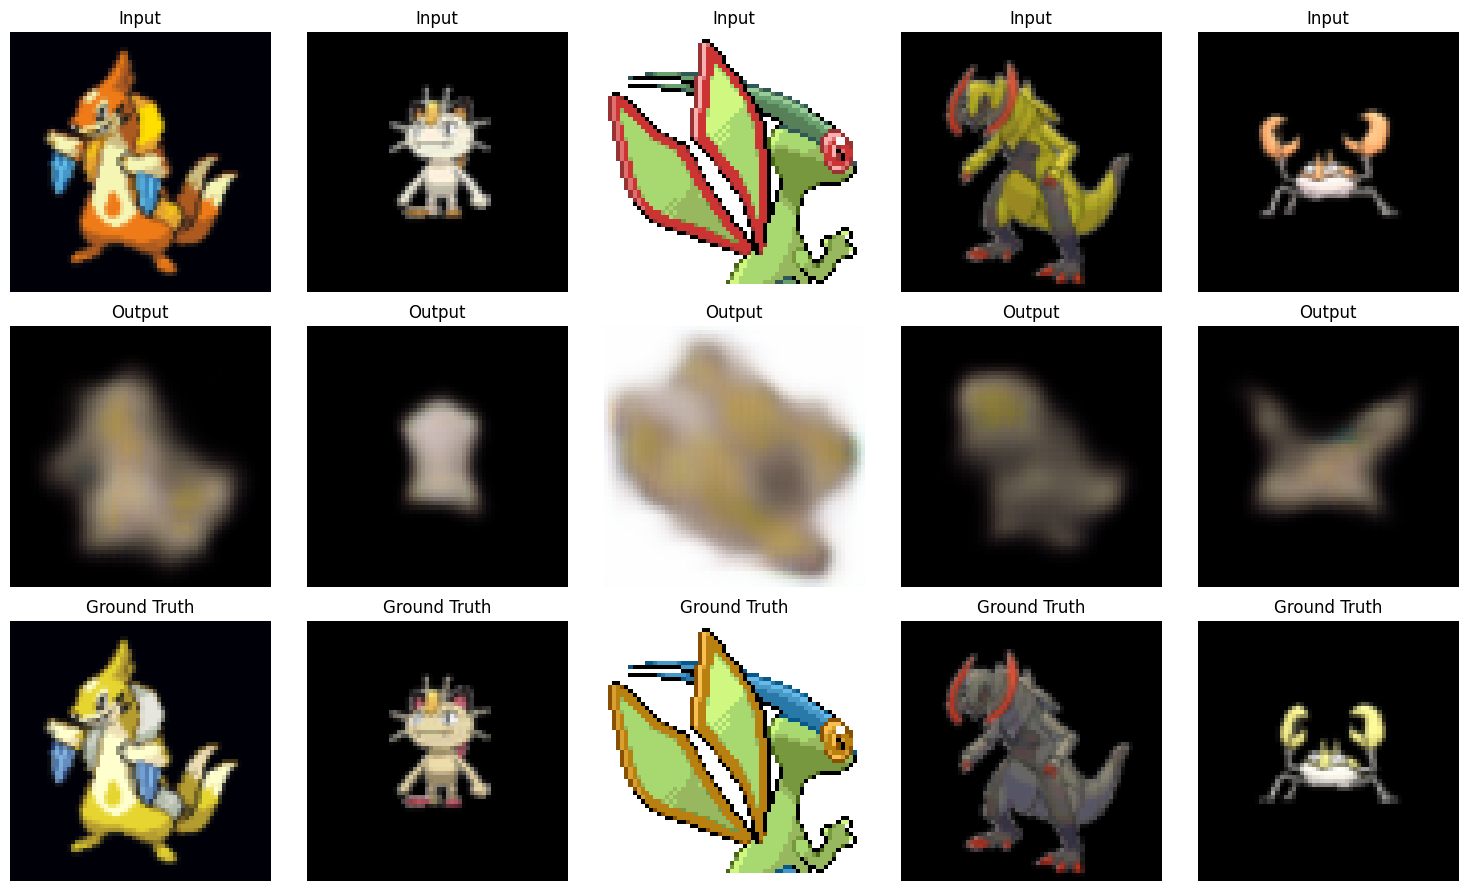

Average Loss on Test Set: 0.04571


In [13]:
import torch
import torch
model.eval()

def show_model_performance(model, test_dl, device):
    total_loss = 0
    criterion = torch.nn.MSELoss()

    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_dl)
    print(f"Average Loss on Test Set: {avg_loss:.5f}")


import matplotlib.pyplot as plt

def show_autoencoder_output(test_dl, model):
    with torch.no_grad():
        for inputs, labels in test_dl:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            inputs = inputs.cpu().numpy()
            outputs = outputs.cpu().numpy()
            labels = labels.cpu().numpy()

            # Plot the input, output, and ground truth images
            fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))

            for i in range(5):
                axes[0, i].imshow(inputs[i].transpose(1, 2, 0))
                axes[0, i].set_title("Input")
                axes[0, i].axis("off")

                axes[1, i].imshow(outputs[i].transpose(1, 2, 0))
                axes[1, i].set_title("Output")
                axes[1, i].axis("off")

                axes[2, i].imshow(labels[i].transpose(1, 2, 0))
                axes[2, i].set_title("Ground Truth")
                axes[2, i].axis("off")

            plt.tight_layout()
            plt.show()
            break


show_autoencoder_output(test_dl, model)
show_model_performance(model, test_dl, device)